## Notebook 4: `4_Neural_Network_Modelling`   

In notebook 3, we tried some additional machine learning models on a sample of dataset.     


In this notebook, we will try some deep learning models on a sample of dataset. First a simple neural network was trained on the transformed data to predict sentiment of tweets. Second, word embeddings were used to train a neural network and logistic regression model.    

The following is the table of contents for this notebook. 

<br>

### Table of Contents 

<br>   

1. [Data Transformation](#transformation)                  
2. [Modelling](#Modelling)        
    2.1 [Neural Network](#NN)    
    2.2 [word2vec](#w2v)
    2.3 [Logistic regression with word2vec](#log_w2v)    
    2.4 [Neural Network with word2vec](#NN_w2v)                      
3. [Conclusion](#conclusion)    

Import required libraries.   

In [1]:
# Basic data science packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Text data packages
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Other required packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


# modeling and metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.dummy import DummyRegressor


import pickle
import joblib

from sklearn.pipeline import Pipeline


# Neural network packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gensim
from gensim.utils import simple_preprocess
from tensorflow.keras.callbacks import EarlyStopping
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

Let's start with training a simple neural network model on vectorized data.

In [2]:
df_clean_whole = pd.read_csv('../data/cleaned_data.csv')

In [3]:
df_clean_whole.head()

,Unnamed: 0,ids,date,user,text,target
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,Awww thats a bummer You shoulda got David Carr...,0
1,1,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he cant update his Facebook by t...,0
2,2,1467810917,2009-04-06 22:19:53,mattycus,I dived many times for the ball Managed to sav...,0
3,3,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,0
4,4,1467811193,2009-04-06 22:19:57,Karoli,no its not behaving at all im mad why am i her...,0


In [4]:
#take a sample from this data set 
df_clean = df_clean_whole.sample(frac=0.1, random_state=1).copy()

In [5]:
df_clean.shape

(153270, 6)

In [6]:
#tokenize the data 
df_clean['cleaned_text'] = df_clean['text'].apply(lambda x: word_tokenize(x))

## Data Transformation  <a name="transformation"></a>

Our goal is to predict sentiment for a given tweet. Stop words such as the, a, an etc. do not contribute to the sentiment for a sentence. I am removing the stop words from tokenized data. 

In [8]:
#create a list of stop words 
stop_words = stopwords.words('english')

In [9]:
#remove stop words from tokenized data
df_clean['cleaned_text'] = df_clean['cleaned_text'].apply(lambda x: [word for word in x if word.casefold() not in stop_words])

Perform stemming.

In [10]:
snowball_stemmer = SnowballStemmer(language='english')
wordnet_stemmer = WordNetLemmatizer()

In [11]:
#perform stemming or lemmetization
df_clean['cleaned_text'] = df_clean['cleaned_text'].apply(lambda x: [snowball_stemmer.stem(word) for word in x])  

Split data into training and validation sets.   

In [17]:
X = df_clean['cleaned_text'].apply(lambda x: ' '.join(x))
y = df_clean['target']

In [18]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, stratify=y)

Transform tokens to document term matrix.  

In [19]:
tfidf_vectorizer = TfidfVectorizer(min_df=20)

In [20]:
tfidf_vectorizer.fit(X_train)

TfidfVectorizer(min_df=20)

In [21]:
X_train_transformed = tfidf_vectorizer.transform(X_train)
X_train_transformed

<122616x3805 sparse matrix of type '<class 'numpy.float64'>'
	with 751712 stored elements in Compressed Sparse Row format>

In [22]:
X_validation_transformed = tfidf_vectorizer.transform(X_validation)

## Modelling <a name="Modelling"></a> 

### Neural Network <a name="NN"></a> 

Keras only deals with dense arrays so let's convert sparse matrix to dense array. 

In [176]:
#convert arrays to dense array so that keras can handle it
X_train_transformed = X_train_transformed.toarray()
X_validation_transformed = X_validation_transformed.toarray()

Create a simple neural network to train.    

In [183]:
#let's create a simple neural network 
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(128, activation="relu", kernel_initializer = 'glorot_uniform'))
model.add(layers.Dropout(0.20)) #dropout layers for regularization 
model.add(layers.Dense(128, activation="relu", kernel_initializer = 'glorot_uniform'))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(128, activation="relu", kernel_initializer = 'glorot_uniform'))
model.add(layers.Dropout(0.1))


# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(), #optimizer
    loss=keras.losses.BinaryCrossentropy(), #Loss function to minimize
    metrics=[keras.metrics.BinaryAccuracy()] #Metrics used to evalute the model 
)



#define the stopping criteria 
callbacks = EarlyStopping(monitor='val_loss', 
                       patience=10, 
                       mode='min', 
                       verbose=1,
                       restore_best_weights=True)

#fit the model 

history = model.fit(X_train_transformed, 
                    y_train, 
                    epochs=20, # the data set is fed through the model 20 times 
                    verbose=0, 
                    # Pass in a validation data set to test each epoch.
                    callbacks=[callbacks],
                    validation_data=(X_validation_transformed, y_validation)) 



Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping


Let's plot the model loss with number of epochs.    

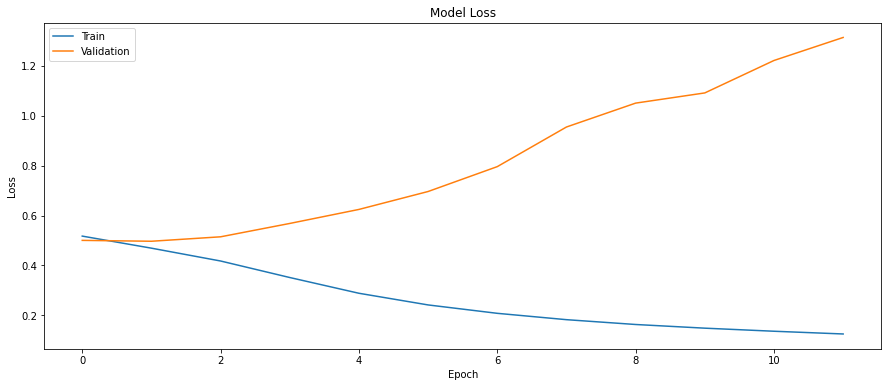

In [185]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

We can see that the training loss goes down with number of epochs while validation loss goes up with the number of epochs. The increase in validation loss represent that the model is learning noise and overfitting.  

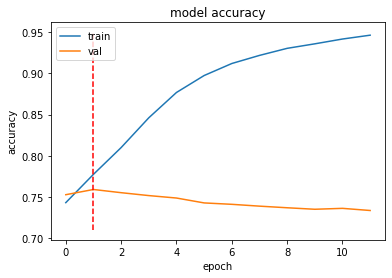

In [196]:
# plot accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.vlines(np.argmax(history.history['val_binary_accuracy']), ymin=0.71, ymax=0.95, linestyles='--', colors='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The figure above shows the model accuracy with the number of epochs. Training accuracy goes up while the validation accuracy goes down after certain number of epochs. This is the point after which complex patterns are learned by the model and model overfits.    

the maximum validation score is 0.76 when epoch is 1. 

Let's predict sentiment for the following sentence.   


In [201]:
tweet = "I like machine learning but deep learning is love"
#tokenize data 
snowball_stemmer = SnowballStemmer(language='english')
stop_words = stopwords.words('english')

tokenized_text = word_tokenize(tweet)
cleaned_text = [word for word in tokenized_text if word.casefold() not in stop_words]
cleaned_text = [snowball_stemmer.stem(word) for word in cleaned_text]

In [202]:
#transform data
tweet_transformed = tfidf_vectorizer.transform(cleaned_text).toarray()

In [206]:
#predict sentiment 
prob_sent = np.mean(model.predict(tweet_transformed))
if prob_sent > 0.5:
    print('tweet has positive sentiment')
else:
    print('tweet has negative sentiment')

tweet has positive sentiment


Our neural network thinks that the sentence has positive sentiment which is kind of true :P        

Save the keras model for later use. 

In [208]:
#save the model 
model.save('basic_neural_network')
#you can load this model by `keras.models.load_model('path/to/location')`

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: basic_neural_network\assets


### word2vec <a name="W2v"></a> 

Until now we have predicted sentiment based on the words observed in training data. For example if the word `good` is in the tweet, the tweet has positive sentiment. Similarly, if the word `best` is not in the training set, our model will not be able to predict the sentiment for this tweet even though both the words has a similar sentiment. In order to make our model learn from similar words in the training set, we can use word embeddings. 

Word embedding is a high dimensional vector representation of words. These vectors are positioned in such a way that the distance between two similar words is minimum. We can use word embeddings to train models on not only the words in the training set but also the similar words from vocabulary of words used to train these word embeddings. 

In [16]:
# load the word2vec word embeddings
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    '../data/lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False
)

Let's create sentence embeddings for our data.

First, tokenize all the documents in the training set using simple_preprocess function. 

In [24]:
# tokenize feature  
df_clean['tokenized'] = df_clean['text'].apply(lambda x: simple_preprocess(x))

Let's store word embeddings for each of the word of a document in a list. If the word present is not found in the vocabulary on which the word embeddings were trained, we will assume it to be zero.  

In [28]:
X_emb = df_clean.tokenized.apply(lambda x: [word2vec[word] if word in word2vec else np.zeros(300) for word in x])

Check out the shape of first document's word embedding. This document has six words hence the shape is `(6, 300)`. 

In [41]:
np.stack(X_emb.iloc[0]).shape

(6, 300)

To find embedding for a document, let's average embeddings for six words. This can be done using the following function. 

In [50]:
def average_emd(x):
    """returns average value from a numpy array
    Parameter
    ---------
    x: np.array, array on which average will be taken
    Returns
    -------
    np.array"""
    
    #if there is embedding for a document 
    if len(x) > 0:
        return np.stack(x).mean(axis=0)
    #if there is no embedding for the document
    else:
        return np.zeros(300)

In [53]:
X_emb = np.array(X_emb.apply(average_emd).tolist())

Split data into training and validation set

In [54]:
X_train, X_validation, y_train, y_validation = train_test_split(X_emb, df_clean['target'], train_size=0.8, stratify=y)

### Logistic regression with word2vec <a name="log_W2v"></a> 

Now that we have sentence embeddings, we can take these embeddings as new features and train additional models on them.   

In the previous notebook we have seen that logistic regression was performing better than other models, so let's first train a logistic regression model.   

In [56]:
#let's train a logistic regression model on this data 
from sklearn.linear_model import LogisticRegression


In [57]:
#initialize model 
log_model = LogisticRegression(C=0.1, max_iter=1000)

In [58]:
#fit the model 
log_model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000)

In [60]:
#predict accuracy 
log_model.score(X_validation, y_validation)

0.726430482155673

The accuracy of logistic regression model is 0.73 which is similar to the basic neural network. Let's optimize the hyper parameter for logistic regression model. 

In [62]:
#create a pipeline 
C = [0.001, 0.01, 0.1, 1, 10, 10, 100]
score_dict = {'C':C, 'train_score': [], 'validation_score': []}

for c in C:

    log_model = LogisticRegression(C=c)

    log_model.fit(X_train, y_train)

    score_dict['train_score'].append(log_model.score(X_train, y_train))
    score_dict['validation_score'].append(log_model.score(X_validation, y_validation))

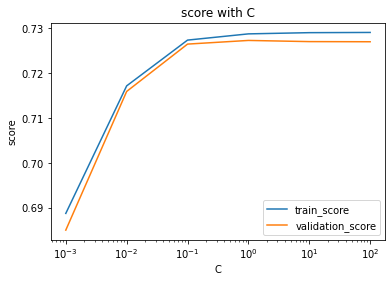

In [64]:
pd.DataFrame(score_dict).plot(x= 'C', y=['train_score', 'validation_score'])
plt.ylabel('score')
plt.title('score with C')
plt.xscale('log')

### Neural Network with word2vec <a name="NN_W2v"></a> 

We can see from the plot above that the optimum value of C where validation score becomes maximum is 0.1. The accuracy of logistic regression model on sample data with sentence embedding as a feature is 0.73. The accuracy for logistic regression on the whole data was 0.77. The accuracy of 0.73 on the 10 percent sample is not bad and the next steps should be to get sentence embeddings for whole data set and train different models.

Let's also train a neural network on these sentence embeddings. 

In [67]:
#let's try a neural network on these embedding vectors
# random seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

# create a new sequential model
model = keras.Sequential()

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(2, activation="softmax")) # output layer

model.compile(
    optimizer=keras.optimizers.Adam(), 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=keras.metrics.SparseCategoricalAccuracy()
)



#define the stopping criteria 
callbacks = EarlyStopping(monitor='val_loss', 
                       patience=10, 
                       mode='min', 
                       verbose=1,
                       restore_best_weights=True)

#fit the model 

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, # the data set is fed through the model 20 times 
                    verbose=0, 
                    # Pass in a validation data set to test each epoch.
                    callbacks=[callbacks],
                    validation_data=(X_validation, y_validation)) 

Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


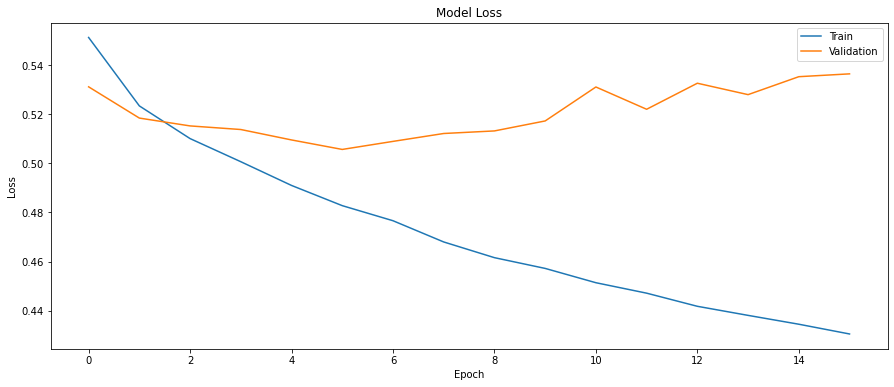

In [68]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

The figure above shows the change in loss over number of epochs. We can see that the training loss decreases while the validation set loss increases with increase in number of epochs. Let's plot accuracy of model with number of epochs.     

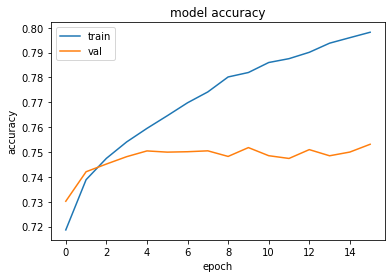

In [72]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

From the figure above we can see that the accuracy of model on training set increases while on validation set decrease with increase in the number of epochs. The accuracy on validation set becomes constant after a point. This is the point after which overfitting occurs. 

It should be note here that the accuracy of neural network on sentence embeddings of only 10 percent of the data is 0.75 percent. If we can have enough computational power to use whole data the accuracy of neural network can exceed 0.77 which was the accuracy of logistic regression model on whole data set.      

## Conclusion     <a name="conclusion"></a> 

In this notebook, we used deep learning models to predict sentiment for the tweets. First a simple neural network was trained on a 10 percent sample of whole data set. The accuracy of neural network was 0.72 on the sample of dataset which was better than some of the machine learning classifiers even when they were trained on the whole data set.     

Second, word2vec model was used to generate word embeddings for each of the word in the sample dataset. These word embeddings then were used to generate sentence embeddings. The sentence embeddings were used as features to train logistic regression and neural network. 

It was found that the neural network trained on the sentence embeddings had a score of 0.75 on validation set even though it was only trained only on the 10 percent of the data set.    

The next steps for this study can be to get enough computational power and train a neural network on the whole dataset to improve accuracy.    


After training these advanced models, we will test our logistic regression model on the data scrapped from twitter.   